# Application of Variational Autoencoder: EMNIST

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

import sys, os
sys.path.append(os.path.abspath(".."))  

from vae import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Non-Convolutional Variational Autoencoder

In [6]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_flat = torchvision.datasets.EMNIST('../data/', train=True, download=True, split='balanced',
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.Resize((img_size,img_size)),
                                          torchvision.transforms.ToTensor(), # creating tensors
                                          torchvision.transforms.Lambda(lambda x: x.transpose(1, 2)),
                                          torchvision.transforms.Lambda((lambda x: torch.flatten(x).to(device))), # Tensor([784])
                            ]))
label_mapping = ds_flat.class_to_idx

### Data Exploration

x.shape: torch.Size([784])
type(t): <class 'int'>


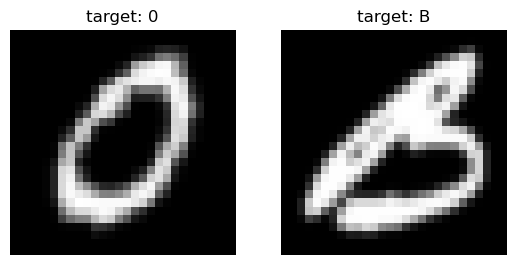

In [7]:
i, j = random.randint(0, 1024), random.randint(0, 1024)
x1,t1 = ds_flat.__getitem__(i)
x2, t2 = ds_flat.__getitem__(j)

print(f"x.shape: {x1.shape}")
print(f"type(t): {type(t1)}")

plt.subplot(1, 2, 1)

draw(x1, f"target: {convert_i2c(t1)}")

plt.subplot(1, 2, 2)
draw(x2, f"target: {convert_i2c(t2)}")
plt.show()

In [8]:
batch_size = 64
ds = torch.utils.data.Subset(ds_flat, range(5000))
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

### Training the Variational Autoencoder

100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


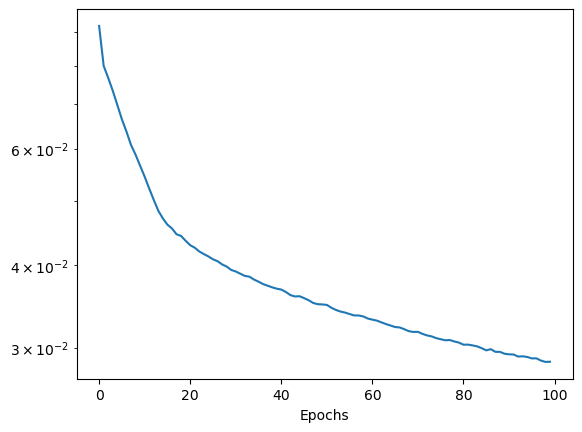

In [10]:
# Training the autoencoder
epochs = 100
lr = 0.001
h_dim = 100
latent_dim = 16
beta = 0.01

vae = VAE(in_dim=img_size**2, h_dim=h_dim,latent_dim=latent_dim, beta=beta,
          decoder=nn.Sequential(
              nn.Linear(latent_dim, 512), nn.ReLU(),
              nn.Linear(512, 1024), nn.ReLU(),
              nn.Linear(1024, img_size**2), nn.Sigmoid()
              ), 
          loss_fcn=nn.MSELoss())
vae.learn(dl, epochs=epochs, lr=lr)

# log_training_session({
#     'epochs': epochs,
#     'lr': lr,
#     'h_dim': h_dim,
#     'latent_dim': latent_dim,
#     'beta': beta,
#     'final_loss': vae.losses[-1]  # final loss after training
# })

In [ ]:
# Save model
model_name = f"../models/vae_mlp_(epochs={epochs})_(lr={lr})_(beta={beta})_(latent_dim={latent_dim}).pth"
torch.save(vae, model_name)

In [ ]:
# Load trained model
# model = torch.load("model/vae_mlp_20e_001lr.pth", weights_only=False)

### Reconstruction of Input using VAE

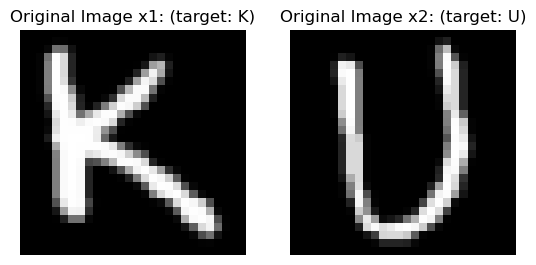

In [12]:
idx1 = random.randint(0, 3204)
x1, t1 = ds_flat.__getitem__(idx1)

idx2 = random.randint(0, 3204)
x2, t2 = ds_flat.__getitem__(idx2)

plt.subplot(1,2, 1)
draw(x1, f"Original Image x1: (target: {convert_i2c(t1)})")
plt.subplot(1,2, 2)

draw(x2, f"Original Image x2: (target: {convert_i2c(t2)})")

In [13]:
# Encode images into latent distributions
mu1, sigma1 = vae.encoder(x1.unsqueeze(0))
mu2, sigma2 = vae.encoder(x2.unsqueeze(0))

### Image Reconstruction

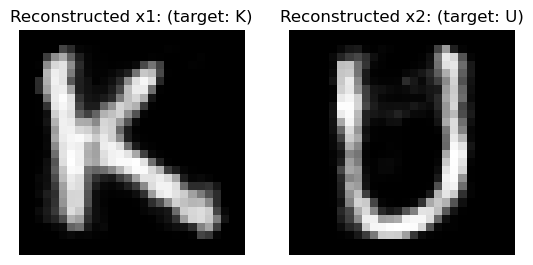

In [14]:
y1 = vae.decoder(mu1)
y1 = y1.squeeze(0)

plt.subplot(1,2,1)
draw(y1, f"Reconstructed x1: (target: {convert_i2c(t1)})")

y2 = vae.decoder(mu2)
y2 = y2.squeeze(0)
plt.subplot(1,2,2)
draw(y2, f"Reconstructed x2: (target: {convert_i2c(t2)})")

### Generative Sampling from Trained VAE

In [19]:
# z = torch.randn(vae.latent_dim)
z = torch.randn(vae.latent_dim)
z

tensor([ 0.6698,  0.4911, -0.1590, -0.8167,  1.7392, -1.6086, -0.3065,  0.2385,
         0.4976, -0.0882,  1.2236, -0.8833,  0.3596,  0.0310,  0.7120,  0.0829])

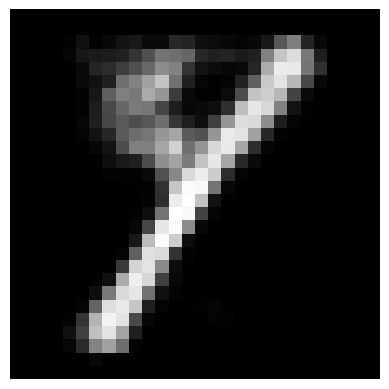

In [20]:
y = vae.decoder(z)
draw(y)